Starting off by watching [this](https://www.youtube.com/watch?v=NE88eqLngkg) video before I read the paper:

One thing that I found quite illustrative was his analogy of momentum as imaginging the weights w as some sort of particle moving through the loss space then we think of $\rho$ the momentum coefficient as being the mass of the particle, and the gradient term being some sort of impulse on a particle with the v term being the current "velocity" of the particle.

## First Pass of Paper

Quickly a definition of SGD: Instead of using all training data we select one or a small batch of training data and get the gradients from that and then do updates. This is faster, and adds a little bit of noise to get out of local minima.

I've experienced myself how it's a bit hard sometimes to pick a good learning rate. It can depend on so many things, network size, data, what activations functions we use, network architecture etc. I've kind of been trial and error-ing to get a good value. SGD also has one global rate. I haven't experienced it myself but sometimes loss landscapes can have long narrow valleys where it oscilates back and forth across the walls.

Before this there are 2 ideas that help to combat this. The first was all the way back in the backprop paper from Rumelhart, which was to add the momentum, a moverage average of past gradients. The second is adaptive learning rates, each parameter gets its own learning rate.

Adam combines these two ideas and adds one important correction to make it work properly.

#### Adam Algorithm
As inputs we have:

$\alpha$ the learning rate (recommended 0.001)

$\beta_{1} \beta_{2}$ the exponential decay rates (recommended 0.9 and 0.999 respectively)

$f(\theta)$ the loss function

$\theta_{0}$ the weights and biases

We then initialize a few vectors

m_0 with the same shape as theta as a vector of 0s, this is the moment vector for momentum

v_0  with the same shape as theta as a vector of 0s, this is for the adaptive learning rates

t = 0 as the timestep counter.

This is the algorithm:
```python
t += 1
g_t = gradient of loss with respect to parameters
m_t = beta_1 * m_t-1 + (1 - beta_1) * g_t
# this allows us to update our weighted moving average (momentum) of the gradients with our fresh ones.
# 0.9 * old gradients + 0.1 * fresh gradients
v_t = beta_2 * v_t-1 + (1 - beta_2) * g_t^2
# this updates our estimate of the uncentered variance of the gradients
# similar structure to m_t update
# we square them to keep track of the magnitude of recent gradients for each parameter -- squaring them makes it sensitive
# to large values, later on when we divide by sqrt vt that means if we're getting a lot of large gradients we'll kind of
# "slow down" and the learning rate will shrink
m_hat_t = m_t / (1 - beta_1 ^ t)
# this is a bias correction step. We initialized our momentum to 0 so it will, at the start, be more biased to 0
# this helps to correct for that, when we have a small t (early in the training) then we'll be dividing by a small number
# making it larger, as t gets larger and larger it will just be the term over 1
v_hat_t = v_t / (1 - beta_2 ^ t)
# same correction as above but for the uncentered variance term
theta_t = theta_t-1 - alpha * m_hat_t / (sqrt(v_hat_t) + epsilon)
# parameter update
# we set the parameters to be the learning rate multiplied by our special term
# our special term is the m_hat_t, (the momentum bias corrected gradients) divided by the square root of the
# v_hat_t our corrected uncentered variance plus a little epsilon so we don't divide by 0 :)
```
Notes:

So this is kind of a smart way to combine things and to remove the bias. It makes a lot of sense to me.

We have the momentum that kind of smooths the movement and gives it more stable direction so we don't oscilate wildly if there's a weird gradient for the batch. We also have the second order term that sets our "speed" correctly. If the gradients we're getting are consistently small, then we'll kind of speed up to cover more ground over this more flat area. If the gradients wer're getting are consistently large, we're in some steepish area so we should slow down so we don't jump all over the place.

##### Description / details of algorithm

An important property is the choice of stepsize. Let's assume epsilon = 0 for simplicity. Aside from just the alpha the core insight is what they call the SNR or signal to noise ratio. which is that special term we multiply by.

The signal is our estimation of the true direction of the gradient, the noise that we divide by is the magnitude of the gradient's fluctuation.

One part that confused me that I just understood: I was looking a lot at the "noise term" or the uncentered variances in isolation. And it seemed strange to me that for this term that is supposed to capture the fluctuations that a bunch of steep gradients in the same direction is interpreted the same as a bunch of steep gradients in different sign directions. One seems to fluctuate while the other seems to just be a steep gradient. That is to say [-30, 30, -30, 30] is interpreted the same as [30,30,30,30] because of the squaring. But what I realized is that you need to also consider how that would affect the m_t term. For the two situations, if they all agree then the momentum will quickly build up and the magnitude will stabalize and we'll get a large update the size of alpha. But in the case of the fluctuating ones the moving average will be around 0 and the magnitude will still be large. Therefore we'll get a very small update because that ratio will be small.

So that leads to the natural question of why does the v_t term matter so much. Like from the above scenario you may think that the momentum term on top is more important. That goes to my previous point.

Imagine now a gentle gradient something like [0.2, 0.2, 0.2] then the momentums will agree in direction, and the v term will be very small, making it a bigger step

If though we have a gradient that's something like [+5, -4, +5, -4] then we'll have a small ish directional concensus, but because the gradients are so large it's a bit of a red flag and it will take smaller steps then. The net signal is weak and the ground is steep.

Now let's look at the upper bound analysis:

There are two scenarios for upper bounds, the more common one is that the special term will roughly equal +/- 1, meaning that the alpha is roughly the upper bound of the size you take in the parameter space. 

Why is this?

We have the ratio of E[g] / sqrt(E[g^2]). This is the expected value / average value of g over the square root of the spread of the values of g. From statistics we know the definition of variance is E[(g - mean)^2] If we expand out the square term and rearrange we get the variance = E[g^2] - mean^2. Again rearranging we get E[g^2] (the second raw moment = variance + mean squared.

We know that the variance must be zero or positive, therefore we know that the second raw moment or E[g^2] >= E[g]^2. We replace the E[g^2] with v hat t our estimate of it, and with m hat t squared, our estimate of E[g]^2. Thus if we do a bit of algebra we do this:

$$
\begin{array}{c}
E[g^2] \ge (E[g])^2 \\
\hat{v}_t \ge (\hat{m}_t)^2 \\
\sqrt{\hat{v}_t} \ge \sqrt{(\hat{m}_t)^2} \\
\sqrt{\hat{v}_t} \ge |\hat{m}_t| \\
\frac{\sqrt{\hat{v}_t}}{\sqrt{\hat{v}_t}} \ge \frac{|\hat{m}_t|}{\sqrt{\hat{v}_t}} \\
1 \ge \frac{|\hat{m}_t|}{\sqrt{\hat{v}_t}} \\
\end{array}
$$

Therefore that special term is always less than or equal to 1 (if the assumption that m hat and v hat are perfect estimators.

Now what happens in the case of "most severe case of sparsity: when a gradient has been zero at all timestamps except at the current timestep"?

I'll spare the algebra, but they show that the step size would be roughly:
$$ \alpha * \frac{1 - \beta_{1}}{\sqrt{1-\beta_{2}}}$$

Using the default values given in the paper that's = 0.00316 which doesn't seem that bad? With an alpha of 0.001 that's around 3 times larger than alpha. This is apparently good because that means the parameter that has not received any gradients so far (or very little) gets a larger boost. This allows it to "catch up" and learn from rare events.

#### Initialization Bias Correction

Where do those corrections come from? The dividing by 1 - beta_2 or 1 - beta_2 ^ t.

Conceptually, when the first gradients arrive, the moving averages are skewed towards that initial zero.

Side note: I wonder after enough time steps is this just wasting computation? Like once t = 100 or something why not just stop doing this. I suppose that

So the correction kind of "boosts" the signal at earlier steps. As the beta term < 1 gets raised to a higher and higher power it will get smaller and smaller, making us divide more by 1. They give a proof of this in the paper.

#### Convergence Analysis

They analyze its convergence using an online learning framework.

Side reading on this:

The online convex optimization framework is a method for analyzing stochastic optimizers. At each timestep t from 1 to T the algorithm will proposet a set of parameters. A convex cost function, the loss on a new batch is revealed. The algorithm incurs a cost on that. The goal of the algorithm is to minimize the total accumulated cost over all steps.

Regret then, R(T), measures how much worse the algorithm performed compared to the best single set of paramters chosen in hindsight. It sums the differences between the per step cost and optimal fixed-point cost. However in the real world they can't calculate the regret, how would they know what the best parameters are when the search space is so large?

A good algorithm will have a regret that grows slower than T. Then it will converge R(T) / T at T -> infinity to 0 regret.

Great!

The authors show their theoretical result of an upper bound on the regret for Adam. They give a proof for this in the appendix. Seems a bit complicated to understand.

#### Related Work / Other Optimizers

AdaGrad -- pretty similar but Adam is better, the difference is that AdaGrad sums all past squared gradients.

RMSProp -- very similar again, two differences: one is that there's a difference in how they apply momentum, rms prop first normalizes the current gradient and then applies the momentum to the rescaled gradient. Adam also has the bias correction.

##### Experiments

They show how much better it is compared to other algorithms. Side note though SGD with Nesterov momentum looks pretty decent.

It beats out other algorithms in:
1. Logistic Regression
2. MLPs

In [5]:
### Try to quickly implement Adam into my training loop

# compare tanh, relu, sigmoid and softplus on same training I had from lenet with MLP
from tensorflow.keras.datasets import mnist
import torch

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)

x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)
print(len(x_train), len(x_test))

import random
import math

class Fully_Connected_Layer():
    def __init__(self, nin, nout, activation_function):
        self.w = torch.randn(nin, nout)
        self.w.mul_(math.sqrt(2.0 / nin)) 
        self.w.requires_grad_()                 
        self.b = torch.randn(nout, requires_grad=True)
        self.activation_function = activation_function

    def __call__(self, x):
        act = (x @ self.w) + self.b
        if(self.activation_function == "relu"):
            return torch.relu(act)
        if(self.activation_function == "tanh"):
            return torch.tanh(act)
        if(self.activation_function == "sigmoid"):
            return torch.sigmoid(act)
        if(self.activation_function == "softplus"):
            return torch.nn.Softplus()(act)
        return act

    def parameters(self):
        return [self.w, self.b]

class MLP():
    def __init__(self, nin, nouts, activation_function):
        sz = [nin] + nouts
        self.layers = [Fully_Connected_Layer(sz[i], sz[i+1], activation_function) for i in range(len(nouts)- 1)]
        self.layers.append(Fully_Connected_Layer(sz[-2], sz[-1], "none"))
        self.activation_function = activation_function

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

def loss_individual(model_outputs, target_label_index):
    max_logit = torch.max(model_outputs)
    shifted_logits = model_outputs - max_logit
    exp = torch.exp(shifted_logits)
    sum_exp = torch.sum(exp)
    target_exp = exp[target_label_index]
    softmax_target = target_exp / sum_exp

    # negative log liklihood
    eps = 1e-12
    loss = -torch.log(softmax_target + eps)
    return loss

60000 10000


In [6]:
class SGD_Optimizer():
    def __init__(self, parameters, learning_rate):
        self.parameters = parameters
        self.lr = learning_rate

    def step(self):
        with torch.no_grad():
            for p in self.parameters:
                p -= self.lr * p.grad

    def zero_grad(self):
        for p in self.parameters:
            p.grad.zero_()

class Adam_Optimizer():
    def __init__(self, parameters, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.parameters = parameters
        self.lr = learning_rate
        self.b1 = beta1
        self.b2 = beta2
        self.eps = epsilon
        self.t = 0
        self.m = [torch.zeros_like(p) for p in self.parameters]
        self.v = [torch.zeros_like(p) for p in self.parameters]

    def step(self):
        self.t += 1
        with torch.no_grad():
            for i, p in enumerate(self.parameters):
                self.m[i] = self.b1 * self.m[i] + (1 - self.b1) * p.grad
                self.v[i] = self.b2 * self.v[i] + (1 - self.b2) * (p.grad**2)
                
                m_hat = self.m[i] / (1 - self.b1**self.t)
                v_hat = self.v[i] / (1 - self.b2**self.t)
                
                p -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

    def zero_grad(self):
        for p in self.parameters:
            p.grad.zero_()



--- Training with optimizer: SGD ---
epoch done...
Finished SGD in 43.42 seconds

--- Training with optimizer: Adam ---
epoch done...
Finished Adam in 76.58 seconds


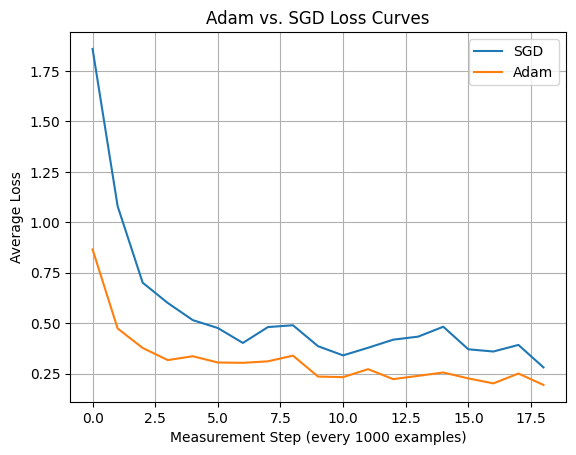

In [12]:
import time
import matplotlib.pyplot as plt

optimizers = ["SGD", "Adam"] 
losses_by_optimizer = {}

for opt_name in optimizers:
    print(f"\n--- Training with optimizer: {opt_name} ---")
    start_time = time.time()
    
    lossi = []
    mnist_mlp = MLP(28*28, [256, 256, 10], "relu")
    
    if opt_name == "SGD":
        optimizer = SGD_Optimizer(mnist_mlp.parameters(), learning_rate=0.001)
    else:
        optimizer = Adam_Optimizer(mnist_mlp.parameters(), learning_rate=0.001)

    lambda_val = 0.0001
    print_reset_error_interval = 1000
    cumulative_error = 0
    epochs = 1
    examples_per_epoch = 20000

    for epoch in range(epochs):
        for i in range(examples_per_epoch):
            flattened = torch.flatten(x_train[i])
            out = mnist_mlp(flattened)
            
            # L2 Regularization
            weights_sum = sum((p**2).sum() for p in mnist_mlp.parameters() if p.dim() > 1)
            
            loss = loss_individual(out, y_train[i].item()) + lambda_val * weights_sum
            loss.backward()

            with torch.no_grad():
                cumulative_error += loss_individual(out, y_train[i].item()).item()

            optimizer.step()
            optimizer.zero_grad()
            
            if (i > 0 and i % print_reset_error_interval == 0):
                lossi.append(cumulative_error / print_reset_error_interval)
                cumulative_error = 0
        print("epoch done...")

    losses_by_optimizer[opt_name] = lossi
    end_time = time.time()
    duration = end_time - start_time
    print(f"Finished {opt_name} in {duration:.2f} seconds")

# Plot all on the same chart
for opt_name, losses in losses_by_optimizer.items():
    plt.plot(losses, label=opt_name)

plt.xlabel(f'Measurement Step (every {print_reset_error_interval} examples)')
plt.ylabel('Average Loss')
plt.title('Adam vs. SGD Loss Curves')
plt.grid(True)
plt.legend()
plt.show()